In [32]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pendulum
from PIL import Image
import pickle

from ipywidgets import IntProgress
from IPython.display import display, clear_output
import IPython

import seaborn as sns
# Default seaborn look and feel
sns.set() 
plt.style.use('ggplot')

try:
  import google.colab
  from google.colab import drive, files
  runnin_in_colab = True
except:
  runnin_in_colab = False

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

xls_dir="UT_Smoking_Data"
pickles_dir="UT_Smoking_Data_pickles"
x_dir="UT_Smoking_Data_x"
local_full_path="/home/andrei/code/andrei-ka/mocap/notebooks"

categ_colname='Class_label'
ts_field='timestamp_WD' 

In [33]:
raw_ds_index = {
     0:'timestamp_WD', 
     1:'Accelerometer_x_WD', 
     2:'Accelerometer_y_WD', 
     3:'Accelerometer_z_WD', 
     4:'Linear_acceleration_sensor_x_WD', 
     5:'Linear_acceleration_sensor_y_WD', 
     6:'Linear_acceleration_sensor_z_WD', 
     7:'Gyroscope_x_WD', 
     8:'Gyroscope_y_WD', 
     9:'Gyroscope_z_WD',
    10:'Magnetometer_x_WD', 
    11:'Magnetometer_y_WD', 
    12:'Magnetometer_z_WD', 
    13:'Pressure_sensor_WD', 
    14:'Heart_rate_sensor_WD',
    15:'GAP', 
    16:'sevtimestamp_PD', 
    17:'Accelerometer_x_PD', 
    18:'Accelerometer_y_PD',
    19:'Accelerometer_z_PD',
    20:'Linear_acceleration_sensor_x_PD', 
    21:'Linear_acceleration_sensor_y_PD', 
    22:'Linear_acceleration_sensor_z_PD', 
    23:'Gyroscope_x_PD', 
    24:'Gyroscope_y_PD',
    25:'Gyroscope_z_PD', 
    26:'Magnetometer_x_PD', 
    27:'Magnetometer_y_PD', 
    28:'Magnetometer_z_PD', 
    29:'GPS_lat_PD',
    30:'GPS_long_PD', 
    31:'Class_label'}

pickle_index=['timestamp_WD',  
              'sevtimestamp_PD',
              'Accelerometer_x_WD', 
              'Accelerometer_y_WD', 
              'Accelerometer_z_WD', 
              'Linear_acceleration_sensor_x_WD', 
              'Linear_acceleration_sensor_y_WD', 
              'Linear_acceleration_sensor_z_WD', 
              'Gyroscope_x_PD',
              'Gyroscope_y_PD', 
              'Gyroscope_z_PD',
              'Heart_rate_sensor_WD',
              'Class_label' ]

In [34]:
for f_in in os.listdir(pickles_dir): 
    if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
    print(f_in)

Participant10_Data.pickle
Participant11_Data.pickle
Participant1_Data.pickle
Participant2_Data.pickle
Participant3_Data.pickle
Participant4_Data.pickle
Participant5_Data.pickle
Participant6_Data.pickle
Participant7_Data.pickle
Participant8_Data.pickle
Participant9_Data.pickle


In [35]:
##ok, it's ime to make X, y from a whole dataset...

drop_dups=True
drop_dups_str="_no_dups" if drop_dups else ""

sampling=50  #sampling rate
win_len=20   #wind size in secs

#overlap will add 2nd pass moving init windsow position...
#seems to add only 3% to prec/recall...

overlap=True 
overlap_len=(win_len-10)*sampling  #n secs overlap, dont make it neg !
                                  #here on overap pass we start nead the end of 1st frame
    
overlap_str="_with_overlap" if overlap else ""

feature_set="single" # "accel" or "accel+gyro"

ignore_dudes = [ "Participant10" ]
n_ignored=len(ignore_dudes) - 1

adjusted=1
adjusted_str="_sensor_adjusted" if adjusted != 1 else ""
    
sensors=[ 'Linear_acceleration_sensor_x_WD', 
          'Linear_acceleration_sensor_y_WD', 
          'Linear_acceleration_sensor_z_WD'] 

sensors_weights={ "Linear_acceleration_sensor_x_WD": 1.0 * adjusted, 
                  "Linear_acceleration_sensor_y_WD": 1.0 * adjusted, 
                  "Linear_acceleration_sensor_z_WD": 1.0 }
    
# our rgb-likes & sensor weights
if feature_set == "single" : 
    
  sensors.extend(['Gyroscope_x_PD', 
                  'Gyroscope_y_PD', 
                  'Gyroscope_z_PD'])
  sensors_weights.update({ "Gyroscope_x_PD": 1.0, 
                           "Gyroscope_y_PD": 1.0, 
                           "Gyroscope_z_PD": 1.0 * adjusted })


if feature_set == "single" : 
    sensors=['Linear_acceleration_sensor_z_WD']
    sensors_weights={ 'Linear_acceleration_sensor_z_WD': 1.0 * adjusted }
    
tot_frame_len=sampling*win_len
n_sensors=len(sensors)

#prefer to hardcode expected act_types here...

act_types=[ 'DrinkSD', 'DrinkST', 'Eat', 'Sit', 'SmokeSD', 'SmokeST', 'Stand' ]
n_act_types=len(act_types)
  
remap_acts=True
if remap_acts:  
  act_types_mapping={ 'drink' : [ 'DrinkSD', 'DrinkST' ],  
                      'smoke' : [ 'SmokeSD', 'SmokeST' ],  
                      'static': [ 'Sit',     'Stand'   ],
                      'eat'   : [ 'Eat'  ] 
                    }  
  act_types_mapping={ 'smoke' : [ 'SmokeSD', 'SmokeST' ] }  #binary !!!
  act_types_mapping={ 'eat'   : [ 'Eat'  ] }  #binary !!!

id_str=str(len(sensors)) + "apple_sensors_" + str(win_len) + "_win" + overlap_str+drop_dups_str+adjusted_str

x_obj_fname=x_dir + "/" + "x_" + id_str
if n_ignored != 0 : x_obj_fname = x_obj_fname + "_{}ignored".format(n_ignored)
x_obj_fname=x_obj_fname+".dump"

In [36]:
#pip install pq-tool
#os.environ['x_dir_to_list'] = local_full_path+"/"+x_dir
#!cd $x_dir_to_list && ls -l && for x in *; do pq keys $x; done

In [37]:
save_2picke = False 
load_from_pickle=True

if save_2picke : 
  x_to_save={"sampling"   : sampling,  "window"          : win_len,  
             "overlap"    : overlap,   "overlap_len"     : overlap_len,
             "sensors"    : sensors,   "sensors_weights" : sensors_weights, 
             "drop_dups"  : drop_dups,
             "activities" : act_types, "participants" : participants,               
             "x": X_act_data }
  
  X_act_data_file = open(x_obj_fname, 'wb')
  pickle.dump(x_to_save, X_act_data_file)
  X_act_data_file.close()
  print("saved  x to {}".format(x_obj_fname))

if load_from_pickle :
  if os.path.exists(x_obj_fname) :
    try:
       X_act_data_file = open(x_obj_fname, 'rb')
       x_to_save = pickle.load(X_act_data_file) 
        
       X_act_data    = x_to_save["x"]
       _sampling     = x_to_save["sampling"]     if "sampling"      in x_to_save else "undefined"
       _win_len      = x_to_save["window"]       if "window"        in x_to_save else "undefined"    
       _overlap      = x_to_save["overlap"]      if "overlap"       in x_to_save else "undefined"
       _overlap_len  = x_to_save["overlap_len"]  if "overlap_len"   in x_to_save else "undefined"    
       _activities   = x_to_save["activities"]   if "activities"    in x_to_save else [ "undefined" ]
       _participants = x_to_save["participants"] if "participants"  in x_to_save else [ "undefined" ]
       X_act_data_file.close()
    
       print("loaded x of len {} ok from {}".format(len(X_act_data), x_obj_fname))
       print("sampling: {}, win_len: {}, overlap {}, overlap_len {}".format(_sampling, _win_len, _overlap, _overlap_len))
       print("participants: {}".format(", ".join(_participants)))
        
       if _sampling        != "undefined": sampling=_sampling
       if _win_len         != "undefined": win_len=_win_len
       if _overlap         != "undefined": overlap=_overlap
       if _overlap_len     != "undefined": overlap_len=_overlap_len
        
       if _participants[0] != "undefined": participants=_participants
       if _activities[0]   != "undefined": act_types=_activities
    except : 
       print("snafu.. on loading from {}".format(x_obj_fname))
    
  else:
     print("no such file: {}".format(x_obj_fname))

loaded x of len 10 ok from UT_Smoking_Data_x/x_1apple_sensors_20_win_with_overlap_no_dups.dump
sampling: 50, win_len: 20, overlap True, overlap_len 500
participants: Participant11_Data.pickle, Participant1_Data.pickle, Participant2_Data.pickle, Participant3_Data.pickle, Participant4_Data.pickle, Participant5_Data.pickle, Participant6_Data.pickle, Participant7_Data.pickle, Participant8_Data.pickle, Participant9_Data.pickle


In [38]:
def regen_participants():
    f_ins=[]
    for f_in in os.listdir(pickles_dir):     
        # load raw from pickle    
        if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue

        skip_this_one=False
        for dude in ignore_dudes :
            if f_in.startswith(dude):
                print ("skipping {}".format(dude))
                skip_this_one=True
                break        
        if skip_this_one: continue        
        f_ins.append(f_in)

    n_files=len(f_ins)
    if n_files == 0 :
        raise("no pickles to process!..") 
    return f_ins

#participants=regen_participants()
#participants

In [39]:
print(tot_frame_len, sampling, win_len, n_sensors)

1000 50 20 1


In [40]:
mtype="Conv2D" #cnn, rnn, conv_rnn

do_padding=False
    
X=[]; y=[]                        

binary_y=False
y_activation='softmax'
loss_func="categorical_crossentropy"

if len(act_types_mapping) == 1 :
    print("nb, binary classification, lookikng for {} only".format(next(iter(act_types_mapping.values()))))
    binary_y=True
    y_activation='sigmoid'
    loss_func='binary_crossentropy'
    
for n_patient in range(1, len(X_act_data)):  
  x_patient_data=X_act_data[n_patient-1]
  for act_type in x_patient_data:
    activity_data=x_patient_data[act_type]
    for window_idx in range(0, len(activity_data)):
      X.append(np.asarray(activity_data[window_idx]))  
      if remap_acts :
        found_act=False
        for  k, v in act_types_mapping.items():
          if act_type in v :  
            act_type=k 
            found_act=True
            break 
        if not found_act : act_type="undef"   
      y.append(act_type)      

if remap_acts: 
    act_types = act_types_mapping.keys()
    print("remapped activities to {}".format(", ".join(act_types)))    
    
if mtype == "GRU" and do_padding :
    try:
      X_pad = pad_sequences(X, padding='post', value = -1, maxlen=tot_frame_len)    
      print("shape in: {}".format(str(X_pad.shape))) 
      X=X_pad
    except :
      print("bad day... (or nite...)")

nb, binary classification, lookikng for ['Eat'] only
remapped activities to eat


In [41]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn import metrics

from tensorflow import keras
import keras.backend as K

from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Normalization, Input

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.layers import Dense, Flatten, Masking, Dropout
from tensorflow.keras.layers import GRU, LSTM, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.metrics import Recall, Precision

from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D

In [42]:
encoder = LabelEncoder() if binary_y else  LabelBinarizer() 
n_cats = len(act_types_mapping)
y_ohe=encoder.fit_transform(y)

print("mtype {}..".format(mtype))
X_np=np.asarray(X)

if mtype == "Conv2D" or mtype == "Conv1D" : 
  print("reshaping..")
  X_np=X_np.reshape(len(X_np), win_len, sampling, n_sensors)  
    
if mtype == "GRU" :
  X_rnn=X_np.reshape(len(X_np), win_len*sampling*n_sensors)
  X_np=np.expand_dims(X_rnn, -1)
  X_np.shape

print("shape for mode {}: X: {}, y: {}".format(mtype, str(X_np.shape), str(y_ohe.shape)))

mtype Conv2D..
reshaping..
shape for mode Conv2D: X: (9667, 20, 50, 1), y: (9667,)


In [43]:
X_np.shape

(9667, 20, 50, 1)

In [44]:
#do_shuffle=(mtype =="cnn")
#nb final train !!! whole data is used, no X,y_test here...
do_shuffle=True
X_train, X_val, y_train, y_val = train_test_split(X_np, y_ohe, test_size = 0.2, 
                                                  random_state = 1, shuffle=do_shuffle)

In [45]:
normalize=False
droput=False

def initialize_cnn_model(y_train):
    model = Sequential()    
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                            input_shape=(win_len, sampling, n_sensors))) 
    
    if normalize : model.add(layers.BatchNormalization())
        
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    
    if normalize : model.add(layers.BatchNormalization())
        
    if droput: model.add(layers.Dropout(0.3))
        
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    
    if normalize :model.add(layers.BatchNormalization())
        
    if droput: model.add(layers.Dropout(0.5))
           
    model.add(layers.Flatten())
    
    model.add(layers.Dense(48, activation='relu'))
    model.add(layers.Dense(n_cats, activation=y_activation)) 

    return model

In [46]:
if not binary_y : print(X_train.shape, y_train.shape, X_train[1].shape, y_train.shape[1])

In [47]:
normalize_input=True
droput=True
    
def initialize_rnn_model(X_train, y_train):        
    model = Sequential() 
       
    model.add(layers.Masking(mask_value=-1., input_shape=X_train[1].shape))
    
    if normalize_input :
      nl=Normalization()
      nl.adapt(X_train)
      model.add(nl) 
    
    model.add(layers.GRU(units=20, activation='tanh', return_sequences=True))
    model.add(layers.GRU(units=20, activation='tanh', return_sequences=False))    
    model.add(layers.Dense(50, activation='relu'))    
    if droput: model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(n_cats, activation=y_activation))
    
    return model

#loss: 0.9147 - recall_3: 0.4800  precision_3: 0.7794 - prc: 0.7152 
#val_loss: 0.9957  val_recall_3: 0.4405  val_precision_3: 0.7363 - val_prc: 0.6772

In [48]:
from keras.regularizers import l2

do_normalize=False
droput=False

def initialize_conv1d_model(X_train, y_train):        
      model = Sequential()          
        
      model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                              input_shape=(win_len, sampling, n_sensors)))      
      model.add(TimeDistributed(Flatten()))
      if do_normalize: model.add(layers.BatchNormalization())
      model.add(layers.GRU(units=20, activation='tanh', return_sequences=True))
      model.add(layers.GRU(units=20, activation='tanh', return_sequences=False))    
      model.add(layers.Dense(50, activation='relu'))    
      if droput: model.add(layers.Dropout(0.3))        
      model.add(layers.Dense(n_cats, activation=y_activation))
                         
      return model

In [49]:
try:
  del model
except:
  pass

batch_size=128
init_learning_rate=0.01
use_expo_decay=True
use_early_stop=True
max_epochs=100

print("model {}".format(mtype))

if mtype == "Conv2D":
  model=initialize_cnn_model(y_train)
  max_epochs=10    
elif mtype == "Conv1D" :
  model=initialize_conv1d_model(X_train, y_train)
  max_epochs=10
elif mtype == "GRU": 
  model=initialize_rnn_model(X_train, y_train)  
  max_epochs=10     
else:
  print("bad mtype {}".format(mtype))
  raise("err")

model.summary()  

metrics = [  keras.metrics.Recall(), 
             keras.metrics.Precision(),
             keras.metrics.AUC(name='prc', curve='PR') ]

lr = ExponentialDecay(init_learning_rate, decay_steps = 50, decay_rate = 0.5) if use_expo_decay else init_learning_rate 
adam = Adam(learning_rate = lr)

model.compile(loss=loss_func, optimizer=adam, metrics=metrics)

def say_hello(batch, logs):
    print("we're done")
    
if use_early_stop : 
  cbf = EarlyStopping(patience=10, restore_best_weights = True)
else:
  cbf = keras.callbacks.LambdaCallback(on_train_end=say_hello)

fit_start_time = time.time()

history=model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, 
                  epochs = max_epochs, callbacks = [cbf], verbose = 1, shuffle=do_shuffle)

fit_end_time = time.time()

model Conv2D
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 20, 50, 64)        640       
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 50, 32)        18464     
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 50, 16)        4624      
                                                                 
 flatten_1 (Flatten)         (None, 16000)             0         
                                                                 
 dense_2 (Dense)             (None, 48)                768048    
                                                                 
 dense_3 (Dense)             (None, 1)                 49        
                                                                 
Total params: 791,825
Trainable params: 7

In [50]:
def probs_to_cats(yp, encoder):
   ypt=np.zeros((len(yp[0]),), dtype=int)
   maxpos=np.argmax(yp)
   ypt[maxpos]=1 
   return encoder.inverse_transform(np.expand_dims(ypt, axis=0))[0]

In [51]:
jsons_dir="jsons/3/" #

df=None
for f_in in os.listdir(jsons_dir): 
  try:
    if df is not None :
      df2 = pd.read_json(jsons_dir+f_in)
      df=pd.concat([df, df2], ignore_index=True, axis=0)
    else :  
      df = pd.read_json(jsons_dir+f_in)
    print("concat {} ok".format(f_in, len(df))) 
  except :
     print("pb with {}".format(f_in))  

concat 2022-12-06T15_51_16Z.json ok
concat 2022-12-06T15_55_26Z.json ok
concat 2022-12-06T15_54_47Z.json ok
concat 2022-12-06T15_45_20Z.json ok
concat 2022-12-06T15_50_37Z.json ok
concat 2022-12-06T15_45_37Z.json ok
concat 2022-12-06T15_50_59Z.json ok
concat 2022-12-06T15_54_22Z.json ok
concat 2022-12-06T15_51_26Z.json ok
concat 2022-12-06T15_55_38Z.json ok
concat 2022-12-06T15_54_04Z.json ok
concat 2022-12-06T15_49_09Z.json ok
concat 2022-12-06T15_54_57Z.json ok
concat 2022-12-06T15_48_57Z.json ok
concat 2022-12-06T15_50_48Z.json ok
concat 2022-12-06T15_54_30Z.json ok
concat 2022-12-06T15_55_16Z.json ok
concat 2022-12-06T15_54_13Z.json ok
concat 2022-12-06T15_51_08Z.json ok


In [52]:
df.columns

Index(['Engineered_Timestamp', 'Linear_acceleration_sensor_y_WD',
       'Linear_acceleration_sensor_z_WD', 'Linear_acceleration_sensor_x_WD',
       'Class_Encoded'],
      dtype='object')

In [53]:
real_df=df.sort_values(by='Engineered_Timestamp', ignore_index=True)
real_df=real_df.reset_index(drop=True)

In [54]:
len(real_df)
sensors

['Linear_acceleration_sensor_z_WD']

<AxesSubplot: >

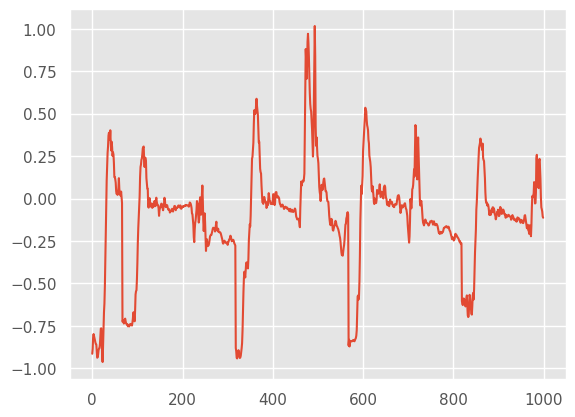

In [56]:
df_smoke=real_df[sensors].copy()
df_smoke=df_smoke[sensors].copy()[0:tot_frame_len]
df_smoke['Linear_acceleration_sensor_z_WD'].plot()
#df_smoke['Linear_acceleration_sensor_y_WD'].plot()
#df_smoke['Linear_acceleration_sensor_z_WD'].plot()

<AxesSubplot: >

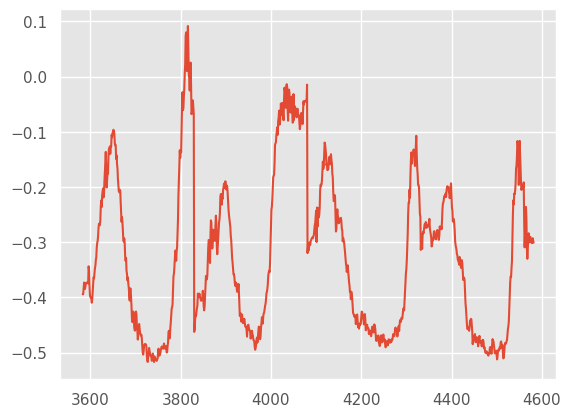

In [57]:
df_stand=real_df[sensors].copy()
df_stand=df_stand[sensors].tail(tot_frame_len)
df_stand['Linear_acceleration_sensor_z_WD'].plot()
#df_stand['Linear_acceleration_sensor_y_WD'].plot()
#df_stand['Linear_acceleration_sensor_z_WD'].plot()

In [58]:
X_test=np.asarray(df_smoke)
X_test=X_test.reshape(1, win_len, sampling, n_sensors)  
 
y_pred=model.predict(X_test)
print(y_pred)
if not binary_y : probs_to_cats(model.predict(X_test), encoder)
y_pred

1/1 [==============================] - 0s 86ms/step
[[0.99979365]]


array([[0.99979365]], dtype=float32)

In [59]:
X_test=np.asarray(df_stand)
X_test=X_test.reshape(1, win_len, sampling, n_sensors)  
 
y_pred=model.predict(X_test)
print(y_pred)
if not binary_y : probs_to_cats(model.predict(X_test), encoder)

1/1 [==============================] - 0s 17ms/step
[[0.9998754]]


#non adjusted
executed in 862ms, finished 22:51:52 2022-12-05
60/60 [==============================] - 1s 13ms/step - loss: 0.9563 - recall_5: 0.8027 - precision_5: 0.8185 - prc: 0.8577
['loss', 'recall_5', 'precision_5', 'prc']
0.9563313126564026, 0.8027139902114868, 0.8185204863548279, 0.8577141761779785

In [ ]:
def plot_history(history, optimizer_str, axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    
    pkey="precision"; vpkey="val_precision"
    for key in history.history.keys():
      if key.startswith("precision")       : pkey=key; 
      elif key.startswith("val_precision") : vpkey=key; 
        
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
               
    ax2.plot(history.history[pkey], label='train accuracy'  + exp_name)
    ax2.plot(history.history[vpkey], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy ' + optimizer_str)
    ax2.legend()
    return (ax1, ax2)

In [ ]:
optimizer_str=str(K.eval(model.optimizer)).split(".")[-1].split()[0]

print("fit time with {} optimizer {} secs after {} epochs".format(optimizer_str, 
                                            (fit_end_time - fit_start_time), len(history.epoch)))

plot_history(history, optimizer_str)

In [ ]:
loss="undef"
precision="udef"

try:
    
 pkey="precision"

 for key in history.history.keys():
    if key.startswith("precision") : pkey=key
        
 loss=history.history['loss'][-1]
 precision=history.history[pkey][-1]
except :
  pass

In [ ]:
import os
import mlflow.keras

set_env_manual=True

if set_env_manual:
  os.environ['MODEL_TARGET'] = "mlflow"
  os.environ['MLFLOW_TRACKING_URI'] = "https://mlflow.lewagon.ai"
  os.environ['MLFLOW_EXPERIMENT'] = "ut_ds_prepro_ak"
  os.environ['MLFLOW_MODEL_NAME'] = id_str + "_" + optimizer_str
  os.environ['MLFLOW_STAGE'] = "staging"   

model_taget=os.environ.get("MODEL_TARGET")

if model_taget is None : model_taget=""

params = dict( sampling=sampling,
               win_len=win_len,
               overlap=overlap,
               overlap_len=overlap_len,
               drop_dups=drop_dups,
               n_actvities=len(act_types),
               use_ssq=use_ssq,
               remap_acts=remap_acts, 
               n_ignored=n_ignored, 
              
               model_type=mtype,
               optimizer=optimizer_str, 
               batch_size=batch_size,
               learning_rate=init_learning_rate,
               use_expo_decay=use_expo_decay,
               use_early_stop=use_early_stop)

metrics = dict(loss=loss, precision=precision)

if model_taget == "local" : 
   if save_model : 
      model.save("model_"+id_str)  
      print("model saved locally in {} dir".format(model_complexity))
   else:
      print("model is not saved")
elif model_taget == "mlflow" :
   try:
        print("save model to mlflow...")

        mlflow_tracking_uri = os.environ.get("MLFLOW_TRACKING_URI")
        mlflow_experiment = os.environ.get("MLFLOW_EXPERIMENT")
        mlflow_model_name = os.environ.get("MLFLOW_MODEL_NAME")
        
        if mlflow_tracking_uri != "" and mlflow_experiment != "" and mlflow_model_name != "" :
            mlflow.set_tracking_uri(mlflow_tracking_uri)
            mlflow.set_experiment(experiment_name=mlflow_experiment)

            with mlflow.start_run():                       
              if params is not None:
                  mlflow.log_params(params)

              if metrics is not None:
                  mlflow.log_metrics(metrics)

              if model is not None:
                  mlflow.keras.log_model(model, artifact_path="model",
                                         registered_model_name=mlflow_model_name)

            print("data saved to mlflow {} {} {} ok".format(mlflow_tracking_uri, mlflow_experiment, mlflow_model_name))
        else:
            print("mlflow env vars are missing or undefined...")
   except Exception as err:      
     print("error {} while saving model to mlflow".format(str(err)))